# Data Portfolio: Predicting Federal Funds Rate Change
    Xander de la Bruere
    Jakob Gertsch
    Sam Layton
    Matt Mella
    Wilson Stoddard

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prince import FAMD
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap

### Research Question Overview

One of the most important and influential indicators of the United States economy is the federal funds rate, commonly referred to as the interest rate. The federal funds rate is a target interest rate set by the Federal Reserve in an attempt to control other key economic indicators. The Federal Reserve seeks to reach its target interest rate by setting a discount rate (the cost banks face to borrow money from other banks in order to meet overnight reserve requirements), engaging in open market operations (reducing or increasing the quantity of U.S. treasury bills available for purchase), and adjusting reserve requirement (the percentage of money banks must keep in reserve rather than lending it to clients) (#1). In practice, the federal funds rate really does prevail as the standard interest rate throughout the economy.

Significantly, an increase or decrease in the federal funds rate impacts levels of personal consumption and spending as well as corporate investment (higher interest rates increase cost to companies of borrowing money). For example, when interest rates are relaively high, consumers have higher incentive to save money (and get interest) rather than spending, and companies have lower incentive to invest (since they must borrow money at a high interest rate to do so), leading to the economy cooling off as a whole. Conversely, lower interest rates increase personal consumption and corporate investment, leading to the economy heating up as a whole. Cumulatively, these personal and corporate decisions, all based on the federal funds rate, have direct and dramatic effects on important economic indicators such as inflation, real GDP, mortgage prices, and unemployment.

Since the federal funds rate influences so many economic outcomes, foreknowledge of changes in the federal funds rate would allow strategic economic decision-making and investment that would both maximize gains and minimize or eliminate potential losses. For this reason, much effort has been exerted to predict changes in the target federal funds rate announced periodically by the Federal Open Market Committee (FOMC), the policy-making team of the Federal Reserve (#2). The FOMC has shared some indicators that it considers in its decisions, including various price indices and labor market indicators (#3), but it does not explicitly share its goals or the way it considers or weights these metrics.

Many predictive bodies, such as the Blue Chip consensus, are relatively successful at predicing changes in the federal funds rate when most or all economic indicators are positive (or negative), but are inconsistent in accuracy when economic conditions are mixed (#4). Using the techniques of logistic regression and classification, we seek to build upon this theory by considering and appropriately selecting critical features from available economic indicators to develop a robust model for predicting changes in the target federal funds rate. In particular, we concern ourselves with finding features that best predict which of three outcomes will occur: 1) a positive change in the federal funds rate, 2) a negative change in the federal funds rate, and 3) no change in the federal funds rate.


Citations:
1. https://www.federalreserve.gov/monetarypolicy/fomc.htm
2. https://www.investopedia.com/terms/f/federalfundsrate.asp
3. https://federalreserve.gov/monetarypolicy/monetary-policy-what-are-its-goals-how-does-it-work.htm
4. https://www.stlouisfed.org/publications/regional-economist/july-2000/inside-the-briefcase-the-art-of-predicting-the-federal-reserve

# Our Data

In our search for data on key economic indicators that might influence the federal funds rate, we looked to the St. Louis Federal Reserve (FRED) website. This site hosts an enormous amount of time series data on economic indicators that have been tracked carefully and methodically for years. In selecting features, we focused on features with data continuously tracked since 1989 (the first year for which FOMC federal funds rate decisions are available) to the present day. We also chose features that we felt were most likely to have predictive power in determining the FOMC's decision to raise or lower interest rate. With these two considerations in mind, we selected the prime loan interst rate, exports, personal consumption, unemployment rate, GDP, vehicle sales, cash flows, housing starts, and a composite indicator, as well as a categorical variable for recession.

As for the dependent variables of interest--the federal funds rate, its percentage point change at each announcement, and the direction of change--we found a dataset provided by Dr. Kuttner, professor of economics at Williams University, containing recorded values of these variables from 1989 to 2019. Using this dataset as a basis, we used FOMC announcement archives to append the remaining shifts in the federal funds rate from 2019 to the present. Finally, since we hypothesized that stock market values and the strength of the dollar might be important factors in the FOMC's decision, we used data available from Yahoo! Finance to add features corresponding to the S&P 500 closing price and US Dollar index.

### Data Visualization and Basic Analysis



Below, we load in the fully concatenated and cleaned dataset containing our independent variables on the left and the dependent variables on the right. We then shift all other variables but those corresponding to the federal funds rate to the values of one week prior to prepare for forecasting. Several rows of this shifted dataset are displayed below.

In [72]:
# properly read in data
df = pd.read_csv('master_data_clean.csv', index_col=0)
df.index = pd.to_datetime(df.index)

df.drop(columns=['ffr', 'change', 'label_day'], inplace=True)
df

,decision,loan,exports,pce,ue,rgdp,cars,recess,gdpd,veloc,house,mich,cli,spx,usd,fed_party,potus_party,mom
1989-08-24,0.0,10.5,4.1,3.95,5.2,3.0,16.547,0.0,3.0,7.307,1332.0,3.5,99.68832,344.700012,101.519997,1.0,1.0,-1.0
1989-08-25,0.0,10.5,4.1,3.95,5.2,3.0,16.547,0.0,3.0,7.307,1332.0,3.5,99.68832,351.519989,101.589996,1.0,1.0,-1.0
1989-08-26,0.0,10.5,4.1,3.95,5.2,3.0,16.547,0.0,3.0,7.307,1332.0,3.5,99.68832,350.519989,101.849998,1.0,1.0,-1.0
1989-08-27,0.0,10.5,4.1,3.95,5.2,3.0,16.547,0.0,3.0,7.307,1332.0,3.5,99.68832,350.519989,101.849998,1.0,1.0,-1.0
1989-08-28,0.0,10.5,4.1,3.95,5.2,3.0,16.547,0.0,3.0,7.307,1332.0,3.5,99.68832,350.519989,101.849998,1.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-04,0.0,8.5,6.0,3.64,3.7,5.2,15.863,0.0,3.5,1.511,1372.0,4.2,99.47179,4594.629883,103.269997,1.0,0.0,0.0
2023-12-05,0.0,8.5,6.0,3.64,3.7,5.2,15.863,0.0,3.5,1.511,1372.0,4.2,99.47179,4569.779785,103.639999,1.0,0.0,0.0
2023-12-06,0.0,8.5,6.0,3.64,3.7,5.2,15.863,0.0,3.5,1.511,1372.0,4.2,99.47179,4567.180176,104.050003,1.0,0.0,0.0
2023-12-07,0.0,8.5,6.0,3.64,3.7,5.2,15.863,0.0,3.5,1.511,1372.0,4.2,99.47179,4549.339844,104.150002,1.0,0.0,0.0


The modified Dataframe $days\_prior$ is each row of the original Dataframe that occured $n$ days (in this case 7) before an announcement. Then the 'ffr' column is the target variable.

A powerful tool we used is Factor Analysis of Mixed Data (FAMD). It combines the power of PCA and MCA to analyze mixed data (Data with numeric and categorical types). It is a great way to visualize the data and see if there are any patterns. We see this in the following plot:

In [73]:
# We split the df into numeric and categorical data
df_numeric = df.drop(['decision', 'recess', 'fed_party', 'potus_party', 'mom'], axis=1)
df_encoded = df[['recess', 'fed_party', 'potus_party', 'mom']]

# Then we scale the numeric data
scaler = StandardScaler()
df_numeric = scaler.fit_transform(df_numeric)
df_numeric = pd.DataFrame(df_numeric, index=df.index)

# The function FAMD imported from prince requires categorical data to
# Be of type 'object' so we convert it since it is already encoded
df_categorical = df_encoded.astype(str)

In [74]:
# By combining the numeric and categorical data we can use FAMD
df_mixed = pd.concat([df_numeric, df_categorical], axis=1)

In [86]:
X = df_mixed
y = df[['decision']].values

# Do FAMD on the data set
famd = FAMD(n_components=2)
X_famd = famd.fit_transform(X)

# Eigenvalues_summary shows the variance explained by each component
# Just like PCA or MCA alone.
famd.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,4.504,19.58%,19.58%
1,3.960,17.22%,36.80%


In [87]:
# Define three colors for the colormap
color1 = 'blue'
color2 = 'green'
color3 = 'red'

# Create a colormap with three distinct colors split into thirds
colors = [color1, color2, color3]
n_bins = 1000  # Number of bins for the colormap
bounds = [0, 0.333, 0.666, 1.0]  # Splitting into thirds

cmap_name = 'custom_colormap'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

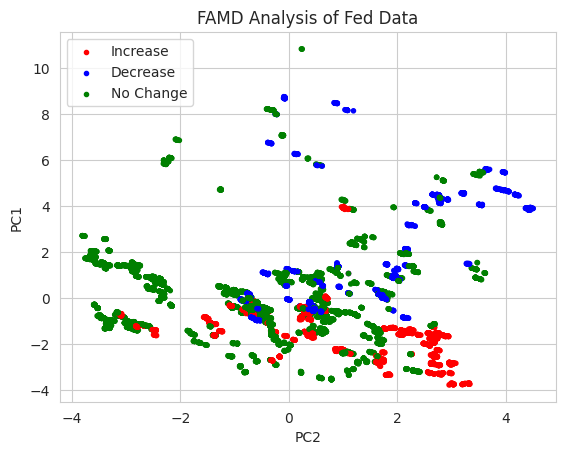

In [88]:
# We now visualize the whole dataset in 2D
plt.scatter(X_famd[:][1], X_famd[:][0], marker='.', c=y.astype(float), cmap=custom_cmap)
plt.title('FAMD Analysis of Fed Data')
plt.xlabel('PC2')
plt.ylabel('PC1')

plt.scatter(X_famd[0][1], X_famd[0][0], label="Increase", color='r', marker='.')
plt.scatter(X_famd[0][1], X_famd[0][0], label="Decrease", color='b', marker='.')
plt.scatter(X_famd[0][1], X_famd[0][0], label="No Change", color='g', marker='.')
plt.legend(loc='upper left')
plt.show()

We see the data is very noisy, but does follow noticable patterns. The colors as shown in the colorbar. 

### Learning Algorithms and In-Depth Analysis

We use random forests and XGBoost for training our models, using the collapsed data and using FAMD to reducethe dimensionality of the data to only 4 principle components. We use grid search to find the best hyperparameters for the models.

In the end, we find that the best model is a random forest with the following hyperparameters:

 {'max_depth': 20,
  'max_features': 'log2',
  'min_samples_leaf': 4,
  'min_samples_split': 5,
  'n_estimators': 50})

  The accuracy matrix for this model is:
                precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.59      0.90      0.71        30
         2.0       0.67      0.30      0.41        20

    accuracy                           0.60        55
   macro avg       0.42      0.40      0.37        55
weighted avg       0.56      0.60      0.54        55

### Ethical Implications

We have attempted to develop a model for predicting changes in the federal funds rate based on available economic indicators. As mentioned previously, the ability to predict changes to this prevailing interest rate before FOMC announcement allows for making strategical decisions to minimize or eliminate losses. For example, a prior prediction of what will happen to interest rates might motivate an individual to move from a low-security job to a high-security job, choose to wait or to rush to get a loan, or sell and buy stocks prior to a big move in the stock market.

Our intent and methodology raise a number of ethical issues. First, attempting to obtain an advantage through  information about the future inherently leads to others who do not share that information facing a disadvantage. For example, someone who has highly credible evidence to believe that the Federal Reserve will decrease the federal funds rate has incentive to sell stocks while keeping this information private so that others do not push the stock price down. Yet by not sharing that evidence, such an individual puts other investors in a more difficult place. Such moral grounds are the basis for material nonpublic information laws that prohibit using, sharing, or selling information about future company decisions that will affect stock prices to turn a profit (#A). While the information obtained through analysis such as that performed in this portfolio is not nearly as certain or exclusive (as the work we have done is highly reproducible), it is still important to acknowledge that successful attempts to predict the market in order to profit will inevitably result in someone losing in a zero-sum, competitive financial world.

Another ethical consideration is the potential loss that could be incurred when too much trust is placed in the prediction of the change in the federal fund rate generated by a model such as ours. With so many factors being weighed and considered by the Federal Reserve, and with economic indicators being so numerous and complex, it is inconceivable that any model used to predict changes in the federal funds rate could have near-perfect accuracy. Those that do not understand the extreme uncertainty involved in both the inputs and outputs to the model are likely to pivot too far, opening themselves up to loss incurred when the actual Federal Reserve decision flies in the face of predictions. In making and sharing predictions, therefore, it is important that equal emphasis and care is placed to express the uncertainty of the outcome, as well as to acknowledge that despite warnings, many will take risks based on the predictions that may have severe economic consequences.

Finally, it is important to note that our aim and methodology of predicting economic outcomes, when implemented and replicated on a large scale, may actually influence the outcomes themselves. Several times throughout history, the mere expectation of economic outcomes or a lack of faith in economic indicators have created economic disasters. For instance, in the events of Black Monday on October 19, 1987, the Dow Jones Industrial Average fell twenty percent in one day. The initial trigger was nervousness about possible overvaluation of stocks and the decline of the dollar, but the crisis was intensified by panic due to a lack of information as to what was happening ("B"). This episode and many others demonstrate that expectations or predictions of what will happen, whether grounded or totally unfounded, can often become a self-fulfilling prophecy. Thus it is possible that initially spurious relationships between economic indicators and interest rates mistakenly included or even emphasized in a model like this one might actually generate an unintended (and perhaps undesired) causal relationship, especially when machine learning is involved. Thus care must be taken to critically analyze how features are included, removed, or split on in such models, especially when destructive self-fulfilling feedback loops can have dramatic financial effects on millions across the country.  

### Citations:
A. https://www.investopedia.com/terms/m/materialinsiderinformation.asp

B. https://en.wikipedia.org/wiki/Black_Monday_(1987)